In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torchsummary import summary
import collections

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [2]:
torch.cuda.empty_cache() # Run if the kernel starts dying, notebook doesn't clear automatically
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Defined for flattening input image inside our model
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [4]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

In [5]:
import cvxpy as cp

def form_milp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i])]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [7]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [8]:
class Model(nn.Module):
    def __init__(self, module_list):
        super(Model, self).__init__()
        self.model = nn.ModuleList(module_list)

    def __iter__(self):
        ''' Returns the Iterator object '''
        return iter(self.model)

    def __len__(self):
        return len(self.model)

    def __getitem__(self, index):
        return self.model[index]

    def __setitem__(self, idx, value):
        self.model[idx] = value

    def register_backward_hooks(self):
        for module_pt in self.model:
            if hasattr(module_pt,'register_masking_hooks'):
                module_pt.register_masking_hooks()
    
    def unregister_backward_hooks(self):
        for module_pt in self.model:
            if hasattr(module_pt,'unregister_masking_hooks'):
                module_pt.unregister_masking_hooks()    

    def forward(self, x):
        for module_pt in self.model:
            x = module_pt(x)
        return x
    
    
    
class FullyConnectedBaselineModel(Model):
    def __init__(self, name='FCBaseline', input_size=784, n_output_classes=10, n_channels=-1):
        self.name = name
        module_list = [
            Flatten(), 
            nn.Linear(input_size, 50), 
            nn.ReLU(True),
            nn.Linear(50, 20), 
            nn.ReLU(True),
            nn.Linear(20, n_output_classes)
        ]

        super(FullyConnectedBaselineModel, self).__init__(module_list)

In [9]:
PATH = '/Users/patrickherbert/Documents/Classes/Spring 2020/DL in DO/Project/mip-for-ann-master/experiments/FCBaseline/lr_2/epoch_20/dataset_0/optimizer_2/exp_4/'

In [10]:
MODEL_PATH = PATH + 'FCBaseline.pt'
model_info = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model_state_dict = model_info.get("model_state_dict")
model = FullyConnectedBaselineModel()
model.load_state_dict(model_state_dict)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
              ReLU-3                   [-1, 50]               0
            Linear-4                   [-1, 20]           1,020
              ReLU-5                   [-1, 20]               0
            Linear-6                   [-1, 10]             210
Total params: 40,480
Trainable params: 40,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


Below is the MaskedLinear class which we need to create in order to make a MaskedModel object and get the weights from that loaded into a normal model.

In [11]:
class MaskedLinear(nn.Module):
    def __init__(self, in_dim, out_dim, indices_mask=None):
        """initialization of masked linear layer
        
        Arguments:
            nn {[type]} -- [description]
            in_dim {int} -- size of input features to linear layer
            out_dim {int} -- size of output features 
        
        Keyword Arguments:
            indices_mask {list} --  list of two lists containing indices for dimensions 0 and 1, used to create the mask, dimension 0 in_dim and dimension 1 out dim which is n neurons (default: {None})
        """        
        super(MaskedLinear, self).__init__()
        if indices_mask is not None:
            self.mask_neurons(indices_mask)
        self.name = 'linear'
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_features = self.linear.in_features
        self.out_features = self.linear.out_features
        self.output_size = self.out_features
        self.input_size = self.in_features
        self.handle = None
        self.has_indices_mask = False

    @staticmethod
    def copy_layer(linear_layer, input_size=-1):
        """clone a pytorch linear layer
        
        Arguments:
            linear_layer {nn.Linear} -- linear layer that would be cloned into MaskedLinear Object
        
        Keyword Arguments:
            input_size {int} -- size of input (default: {-1})
        
        Returns:
            MaskedConv -- returns a cloned MaskedConv object of the pytorch layer
        """        
        new_layer = MaskedLinear(
            linear_layer.in_features, linear_layer.out_features)
        # copy weights to the new layer
        new_layer.linear.weight.data = copy.deepcopy(linear_layer.weight.data)
        new_layer.linear.bias.data = copy.deepcopy(linear_layer.bias.data)
        return new_layer

    def mask_neurons(self, indices_mask):
        """mask neurons on the output dimension of the Linear layer based on input indices
        
        Arguments:
            indices_mask {list} -- list of indices of parameters to be masked in Linear layer
        """        
        if len(indices_mask) > 0:
            self.has_indices_mask = True
        self.mask = torch.zeros([self.out_features, self.in_features]).bool()
        if indices_mask.ndim == 1:
            self.mask[indices_mask, :] = 1
        else:
            self.mask[indices_mask] = 1  # create mask
        self.mask_cached_neurons()

    def mask_cached_neurons(self):
        """
        set masked weights to zero
        """        
        if self.has_indices_mask:
            self.linear.weight.data[self.mask] = 0

    def backward_hook(self, grad):
        """
        a callback backward hook called by pytorch during gradient computation
        
        Arguments:
            grad {tensor} -- gradients of the parameter that pytorch registered this hook on
        
        Returns:
            [tensor] -- updated gradients
        """  
        # Clone due to not being allowed to modify in-place gradients
        out = grad.clone()
        out[self.mask] = 0
        return out

    def register_masking_hooks(self):
        """
        register backward hook on convolutional weights for backprop through a sparse model
        """   
        if self.has_indices_mask and self.handle is None:
            self.handle = self.linear.weight.register_hook(self.backward_hook)

    def unregister_masking_hooks(self):
        """
        unregister an existing masking hooks after finishing trainingbecause hooks would make predictions slower
        """  
        if self.handle is not None:
            self.handle.remove()

    def forward(self, x):
        """
        forward pass on input
        
        Arguments:
            input {Tensor} -- input image that will pass through linear layer
        
        Returns:
            tensor -- Linear layer output
        """  
        x = self.linear(x)
        if self.has_indices_mask:
            assert (self.linear.weight.data[self.mask] == 0).all()
        return x

Then we define a new masked model object to load this into so that we can get the linear weights out. 

In [12]:
class MaskedFCBM(Model):
    def __init__(self, name='MaskedFCBM', input_size=784, n_output_classes=10, n_channels=-1):
        self.name = name
        module_list = [
            Flatten(), 
            MaskedLinear(input_size, 50), 
            nn.ReLU(True),
            MaskedLinear(50, 20), 
            nn.ReLU(True),
            MaskedLinear(20, n_output_classes)
        ]

        super(MaskedFCBM, self).__init__(module_list)

In [13]:
MASK_PATH = PATH + 'FCBaseline_MASK_model_finetuned.pt'
#MASK_PATH = PATH + 'FCBaseline_MASK.pt'
mask_model_info = torch.load(MASK_PATH, map_location=torch.device('cpu'))
mask_state_dict = mask_model_info.get("model_state_dict")
masked_model = MaskedFCBM()
masked_model.load_state_dict(mask_state_dict)
summary(masked_model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
      MaskedLinear-3                   [-1, 50]               0
              ReLU-4                   [-1, 50]               0
            Linear-5                   [-1, 20]           1,020
      MaskedLinear-6                   [-1, 20]               0
              ReLU-7                   [-1, 20]               0
            Linear-8                   [-1, 10]             210
      MaskedLinear-9                   [-1, 10]               0
Total params: 40,480
Trainable params: 40,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.17
---------------------------------------------

Removing the linear part of the saved weights

In [14]:
d = collections.OrderedDict()
for name, param in masked_model.named_parameters():
    if param.requires_grad:
        name = name.replace(".linear", "")
        d[name] = param.data
new_masked_model = FullyConnectedBaselineModel() # Loads masked weights into a normal FCBM model
new_masked_model.load_state_dict(d)

<All keys matched successfully>

In this section you can play around with different variable values for the MIP program and change values to mess with individual images and run them on the trained model. The index of the maximum value in the resulting array corresponds to the predicted image label. Here we should be able to see a slight difference in the predicted values for each of the different models.

In [67]:
epsilon = 0.1 # Change how much the pixels can change in order to create an adversarial example
im_num = 2    # Change which test image we're accessing (i = 0,...,99)
new_label = 5 # Set the label for which we want to find an adversarial example for im_num, 0 for 0 and so on up to 9

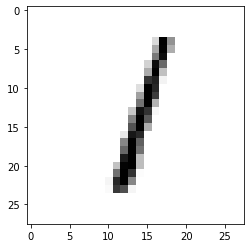

In [68]:
matplotlib.pyplot.imshow(1-X[im_num][0].cpu().numpy(), cmap='gray');

In [49]:
test_data = X[im_num:im_num+1][0]
model(test_data)

tensor([[-9.2966, 12.4353,  0.8562, -2.1959,  1.8975,  0.5165, -5.8936,  0.6549,
          1.1780, -1.6546]], grad_fn=<AddmmBackward>)

In [50]:
new_masked_model(test_data)

tensor([[-10.2658,  11.9540,   0.3126,  -1.5795,   2.3502,  -1.1299,  -6.5017,
           1.7842,   1.4604,  -1.0644]], grad_fn=<AddmmBackward>)

And then set it up the problem to feed into Gurobi

In [56]:
initial_bound = ((X[im_num:im_num + 1] - epsilon).clamp(min=0), (X[im_num:im_num + 1] + epsilon).clamp(max=1))
bounds_m = bound_propagation(new_masked_model, initial_bound) # Change model to masked_model or vice versa
bounds = bound_propagation(model, initial_bound) 

c = np.zeros(10)        # Creating the objective function for the MIP
c[y[im_num].item()] = 1 # y is the correct label for the image selected, setting it to 1 minimzes it in the O.F.
c[new_label] = -1       # Maximize the incorrect label we set above in the O.F.


prob, (z, v) = form_milp(model, c, initial_bound, bounds) # Change model to masked_model or vice versa
prob_m, (z_m, v_m) = form_milp(new_masked_model, c, initial_bound, bounds_m)

Solve MIP to find an adversarial example, if the O.F.V is negative then we have successfully found one. 

In [57]:
prob.solve(solver=cp.GUROBI, verbose=True) # Solve normal model

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 1858 rows, 934 columns and 82598 nonzeros
Model fingerprint: 0xf6d93b33
Variable types: 864 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [7e-06, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 4e+01]
Presolve removed 1649 rows and 10 columns
Presolve time: 0.08s
Presolved: 209 rows, 924 columns, 78358 nonzeros
Variable types: 855 continuous, 69 integer (69 binary)

Root relaxation: objective -1.204697e+02, 157 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -120.46973    0   40          - -120.46973      -     -    0s
     0     0 -116.38

 20821  3752  -37.28388   26   52  -28.40262  -37.61820  32.4%  32.7  397s
 20822  3753  -33.72562   31   52  -28.40262  -37.61820  32.4%  32.7  400s
 20824  3754  -37.02749   28   52  -28.40262  -37.61820  32.4%  32.7  406s
 20826  3756  -34.60635   31   52  -28.40262  -37.61820  32.4%  32.7  412s

Cutting planes:
  Gomory: 2
  Projected implied bound: 393
  MIR: 111
  Flow cover: 103
  Relax-and-lift: 3

Explored 20826 nodes (808488 simplex iterations) in 413.39 seconds
Thread count was 8 (of 8 available processors)

Solution count 7: -28.4026 -28.3158 -28.0307 ... -24.45

Solve interrupted
Best objective -2.840261867857e+01, best bound -3.761820276055e+01, gap 32.4462%


-28.40261867857003

Now we can plot the perturbed image that we found to see what it looks like.


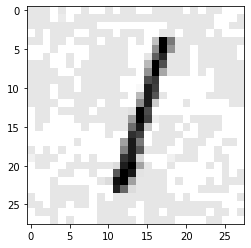

In [58]:
plt.imshow(1-z[0].value.reshape(28,28), cmap="gray");

In [59]:
prob_m.solve(solver=cp.GUROBI, verbose=True) # Solve masked model

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 1858 rows, 934 columns and 79462 nonzeros
Model fingerprint: 0xd2270a66
Variable types: 864 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [6e-06, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 4e+01]
Presolve removed 1657 rows and 16 columns
Presolve time: 0.09s
Presolved: 201 rows, 918 columns, 75911 nonzeros
Variable types: 851 continuous, 67 integer (67 binary)

Root relaxation: objective -1.220040e+02, 165 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -122.00402    0   39          - -122.00402      -     -    0s
     0     0 -117.54

-27.59424622501823

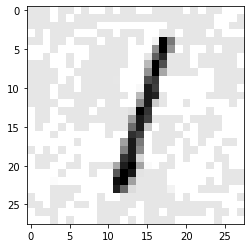

In [62]:
plt.imshow(1-z_m[0].value.reshape(28,28), cmap="gray");

Finally, we run the perturbed image through the trained model as a sanity check to validate the results we found. 

In [63]:
perturbed_data = torch.tensor(z[0].value).float()
perturbed_data = perturbed_data.view(1,28,-1)
model(perturbed_data) # Print perturbed normal model results

tensor([[-15.5762,  -4.7535,  -6.8995,  10.0819,  -9.0895,  23.6491,   7.0851,
           2.4542,   6.9296,  -2.5455]], grad_fn=<AddmmBackward>)

In [64]:
perturbed_data = torch.tensor(z_m[0].value).float()
perturbed_data = perturbed_data.view(1,28,-1)
model(perturbed_data) # Print perturbed masked model results

tensor([[-13.1375,  -5.1264,  -7.7495,   7.9503,  -7.9970,  22.9326,   7.8789,
           1.9800,   6.4039,  -1.8912]], grad_fn=<AddmmBackward>)

## To-Do List:
- Evalute accuracy of both models on the test set
- Find subset of images that fool the pruned model but not the original model or maybe vice versa
- Make models with different levels of sparsity and see how that affects the MIP result (difference of prob), MIP running time
- Print out all the adversarial examples found by the MIP not just the optimal one